# Differential correlation analysis

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline
import itertools

In [2]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq')
import encode
import memento

In [3]:
pd.set_option('display.max_rows', None)

In [4]:
data_path = '/data_volume/memento/hbec/'
fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig6/'

In [5]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [6]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

### Get canonical TFs

In [7]:
tf_df = pd.read_csv('../baseline/human_tf.txt', sep='\t')
tf_list = tf_df['Symbol'].tolist()
tf_list += ['CIITA', 'NLRC5']

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [8]:
# adata_processed = sc.read(data_path + 'HBEC_type_I_processed_deep.h5ad')

In [9]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

In [10]:
adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
# adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
# adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [11]:
converter = {'basal/club':'BC', 'basal':'B', 'ciliated':'C', 'goblet':'G', 'ionocyte/tuft':'IT', 'neuroendo':'N'}

In [12]:
adata.obs['ct'] = adata.obs['cell_type'].apply(lambda x: converter[x])

### Setup memento

In [13]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [14]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [15]:
memento.setup_memento(adata, q_column='q', trim_percent=0.1)

Version 0.0.6


In [16]:
isg_classes = pd.read_csv('../isg_classes.csv')

In [17]:
t1_isg = isg_classes.query('overall_type =="type1"').gene.tolist()
t2_isg = isg_classes.query('overall_type =="type2"').gene.tolist()
shared_isg = isg_classes.query('overall_type == "shared"').gene.tolist()
all_isg = isg_classes[isg_classes.sum(axis=1) > 0].gene.tolist()

In [18]:
tf_isg = list(set(all_isg) & set(tf_list))

### Compare Type 1 vs 2 IFN's TFs

In [19]:
ct = ['C']
adata_stim = adata.copy()[

    adata.obs.ct.isin(ct) & \
    adata.obs.stim.isin(['beta', 'gamma'])].copy()

adata_stim.obs['group'] = 1
# adata_stim.obs['time_step'] = adata_stim.obs['time']#.astype(int).apply(lambda x: time_converter[x])
# adata_stim.obs['time'] = 'tp_' + adata_stim.obs['time'].astype(str)#.apply(lambda x: time_converter[x])

memento.create_groups(adata_stim, label_columns=['donor', 'stim'])
memento.compute_1d_moments(adata_stim, min_perc_group=.9)
# moment_1d_df = memento.get_1d_moments(adata_stim, groupby='is_stim')

available_tfs = list(set(tf_isg) & set(adata_stim.var.index))
available_isgs= list(set(all_isg) & set(adata_stim.var.index))

memento.compute_2d_moments(adata_stim, list(itertools.product(available_tfs, available_isgs)))

corr_df = memento.get_2d_moments(adata_stim, groupby='stim')
m_df, v_df = memento.get_1d_moments(adata_stim, groupby='stim')
# memento.ht_2d_moments( 
#     adata_stim, 
#     formula_like='1 + donor',
#     treatment_col='Inter', 
#     num_boot=10000, 
#     verbose=1,
#     num_cpus=94,
#     resampling='bootstrap',
#     approx=False)

# moment_df = memento.get_2d_moments(adata_stim, groupby='group')
# rho = memento.get_2d_ht_result(adata_stim)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:614: RuntimeWarning: invalid value encountered in true_divide


In [20]:
m_df.query('gene in @tf_isg')

gene  stim_gamma  stim_beta
3       HES4    0.891913   1.606221
162      ID3   -1.116973  -0.420639
822    BLZF1   -1.322169  -0.758888
1604   STAT1    1.642508   1.893595
1730   SP110    0.453337   1.177693
1731  SP140L   -1.000706  -0.582742
1732   SP100    0.551412   1.185239
2265  PLSCR1    1.025429   1.951509
3129    IRF1    2.080251   1.214589
3389     ID4   -1.534923  -0.730823
3551    ETV7   -0.267561  -0.043846
3719   PRDM1   -1.281530  -1.616857
4344  PARP12   -0.525164   0.585755
5035  ZNF618   -2.473703  -1.723412
5129   PRRX2   -1.323308  -0.733785
5645    IRF7   -0.306095   1.113631
5673   ASCL2   -2.460407  -2.002810
5933   BATF2   -1.437017  -1.500840
6512   STAT2    0.351116   1.049121
6525   DDIT3   -0.581991  -0.657512
7046    IRF9    1.032317   1.189679
7830   CIITA   -0.253050  -1.151002
8007   NLRC5   -0.992910  -0.925473
8348  SREBF1   -0.271594  -0.257254
9876   ZNFX1   -0.122783   0.668111

In [22]:
corr_df['diff'] = corr_df['stim_gamma'] - corr_df['stim_beta']

In [23]:
corr_df.groupby('gene_1')['diff'].mean().sort_values()

gene_1
IRF7     -0.261029
PARP12   -0.197072
BLZF1    -0.172217
ZNFX1    -0.169581
PLSCR1   -0.166044
ETV7     -0.165364
STAT1    -0.147944
IRF1     -0.142323
ASCL2    -0.138064
SP100    -0.137619
SP110    -0.133747
HES4     -0.133702
SP140L   -0.132177
ID3      -0.128344
BATF2    -0.124204
IRF9     -0.118002
ID4      -0.107872
ZNF618   -0.103202
NLRC5    -0.097247
SREBF1   -0.086079
STAT2    -0.083233
DDIT3    -0.067810
PRRX2    -0.060810
PRDM1    -0.010965
CIITA     0.025061
Name: diff, dtype: float64

In [24]:
corr_df.sort_values('diff', ascending=False).head(30)

gene_1      gene_2  stim_gamma  stim_beta      diff
8247    CIITA      STXBP1    0.266683  -0.166465  0.433148
8595    CIITA     N4BP2L1    0.489612   0.074572  0.415041
6235    STAT1        GBP2    0.616817   0.220199  0.396618
6093   SP140L       CIITA    0.459627   0.111347  0.348279
8467    CIITA      SP140L    0.459627   0.111347  0.348279
4609   PARP12  AC083862.3    0.568243   0.225670  0.342573
6503    STAT1       CIITA    0.536502   0.197912  0.338589
8313    CIITA       STAT1    0.536502   0.197912  0.338589
8396    CIITA       DRAM1    0.301109  -0.035687  0.336796
8404    CIITA       APOL6    0.632215   0.315722  0.316493
8541    CIITA       ACOX3    0.461680   0.145705  0.315975
6349    STAT1      BTN2A2    0.411085   0.095176  0.315909
8809    ZNFX1      BTN2A2    0.408181   0.092392  0.315789
915     NLRC5        PDP1    0.291927  -0.021547  0.313474
10039   SP100      BTN2A2    0.277127  -0.035115  0.312242
7195    STAT2     L3HYPDH    0.533590   0.225788  0.307801
8450    CIITA       PRRT2    0.244151  -0.063276  0.307427
3757     IRF1     SLC16A9    0.367731   0.060824  0.306906
1541    BATF2       RIPK2    0.333885   0.028236  0.305649
7746    ASCL2       ACSL5    0.259679  -0.044910  0.304589
2507    PRDM1      STXBP1    0.168377  -0.133270  0.301647
6171    STAT1    HLA-DQB1    0.553033   0.255107  0.297926
8401    CIITA    TNFRSF14    0.406093   0.109927  0.296167
2673    PRDM1     ST8SIA4    0.317934   0.023356  0.294578
8218    CIITA         NMI    0.292312  -0.002234  0.294546
8285    CIITA        GBP2    0.528903   0.236916  0.291986
4185     ETV7        GBP2    0.627911   0.336738  0.291172
7034    STAT2     SLC31A2    0.186182  -0.102568  0.288749
2249     IRF9      BTN2A2    0.258836  -0.028749  0.287585
1053    NLRC5       GSTK1    0.171898  -0.112469  0.284367

### Compare STAT1, STAT2, and STAT3

In [30]:
# First, get correlations without adjustment
stim = 'gamma'
ct = ['C']
adata_stim = adata.copy()[

    adata.obs.ct.isin(ct) & \
    adata.obs.stim.isin([stim])].copy()

adata_stim.obs['group'] = 1
# adata_stim.obs['time_step'] = adata_stim.obs['time']#.astype(int).apply(lambda x: time_converter[x])
# adata_stim.obs['time'] = 'tp_' + adata_stim.obs['time'].astype(str)#.apply(lambda x: time_converter[x])

memento.create_groups(adata_stim, label_columns=['donor', 'group'])
memento.compute_1d_moments(adata_stim, min_perc_group=.9)
# moment_1d_df = memento.get_1d_moments(adata_stim, groupby='is_stim')

available_tfs = list(set(tf_list) & set(adata_stim.var.index))
available_isgs= list(set(all_isg) & set(adata_stim.var.index))

memento.compute_2d_moments(adata_stim, list(itertools.product(['STAT1', 'STAT2', 'IRF9', 'STAT3'], available_isgs)))

memento.ht_2d_moments( 
    adata_stim, 
    formula_like='1 + donor',
    treatment_col='Inter', 
    num_boot=10000, 
    verbose=1,
    num_cpus=94,
    resampling='bootstrap',
    approx=False)

moment_df = memento.get_2d_moments(adata_stim, groupby='group')
rho = memento.get_2d_ht_result(adata_stim)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    6.6s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   15.9s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:   26.4s
[Parallel(n_jobs=94)]: Done 1062 tasks      | elapsed:   38.6s
[Parallel(n_jobs=94)]: Done 1702 out of 1702 | elapsed:   56.1s finished
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:614: RuntimeWarning: invalid value encountered in true_divide


In [25]:
list(itertools.product(['STAT1', 'STAT2', 'IRF9', 'STAT3'], available_isgs))

[]

In [32]:
# make data into wideform
wideform = pd.pivot(rho, index='gene_2', columns='gene_1', values=['corr_coef', 'corr_se'])

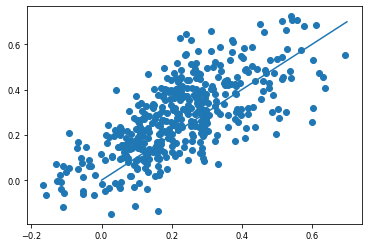

In [44]:
plt.scatter(wideform.loc[:, 'corr_coef'].loc[:,'STAT2'], wideform.loc[:, 'corr_coef'].loc[:,'STAT1'])
plt.plot([0,0.7], [0., 0.7])

In [35]:
wideform.head(50)

corr_coef                                 corr_se            \
gene_1          IRF9     STAT1     STAT2     STAT3      IRF9     STAT1   
gene_2                                                                   
ABAT        0.002681  0.097764  0.076275  0.150555  0.062830  0.042723   
AC004264.1 -0.048714  0.065717  0.092692  0.162631  0.047439  0.032458   
AC009119.1  0.212263  0.140635  0.085799  0.004021  0.053423  0.033180   
AC009133.1  0.132745  0.407170  0.478238  0.278694  0.069041  0.049699   
AC009950.1  0.059131  0.259783  0.172311  0.105970  0.086935  0.062974   
AC016831.1  0.013393  0.097156  0.120782  0.024964  0.055408  0.038491   
AC022034.1  0.187724  0.473170  0.470239  0.198831  0.057301  0.042257   
AC027117.1  0.115847  0.313191  0.399148  0.220573  0.067961  0.052273   
AC073111.4  0.049345  0.202775  0.256896  0.177791  0.093842  0.072244   
AC083862.3  0.090473  0.290457  0.417314  0.129622  0.093831  0.072266   
AC124319.1  0.119012  0.375478  0.488407  0.287343  0.057723  0.042455   
ACE2        0.101439  0.212740  0.169311  0.033821  0.067377  0.057686   
ACKR4       0.251098  0.310099  0.204330  0.294568  0.070438  0.052889   
ACOX3       0.303324  0.287088  0.359425  0.187636  0.084228  0.059461   
ACP2        0.096740  0.319095  0.204474  0.287073  0.079534  0.056819   
ACSL1       0.128566  0.303438  0.243542  0.217279  0.069000  0.053459   
ACSL5       0.041940  0.352956  0.225294  0.241777  0.087167  0.069554   
ADAM28      0.045944  0.451334  0.269286  0.200927  0.037129  0.029493   
ADAM8      -0.087721 -0.149050  0.028339 -0.061194  0.047031  0.032122   
ADAR        0.307668  0.530720  0.480270  0.384371  0.056572  0.039140   
AKAP7       0.143041  0.147891  0.050056  0.102247  0.079118  0.051363   
AL021707.6  0.007488  0.187672  0.408751 -0.023264  0.081045  0.060318   
AL353807.5  0.061294  0.238353  0.288590  0.048730  0.084389  0.060893   
ANKFY1      0.185085  0.256680  0.601662  0.264911  0.082625  0.060414   
ANKRD22    -0.027883  0.253731  0.144508  0.061886  0.047951  0.049118   
ANKRD45     0.302507  0.082674  0.120686  0.193641  0.066151  0.045591   
APOBEC3A   -0.024343 -0.011970  0.038481  0.101911  0.027471  0.021724   
APOBEC3F    0.320746  0.386184  0.218986  0.248421  0.106927  0.080967   
APOBEC3G    0.258700  0.329388  0.145287  0.173577  0.066567  0.044808   
APOD        0.148347 -0.062456 -0.053345 -0.001990  0.043251  0.028422   
APOL1       0.116972  0.425491  0.369466  0.267314  0.040228  0.032610   
APOL2       0.151762  0.455748  0.385517  0.352322  0.046342  0.030290   
APOL3       0.064398  0.324486  0.172358  0.215314  0.068058  0.051465   
APOL4       0.163583  0.401070  0.319350  0.291340  0.052939  0.039074   
APOL6       0.358835  0.687886  0.610445  0.319141  0.041433  0.025339   
AQP5       -0.061112  0.289248  0.154291  0.106413  0.028469  0.023637   
ASAP3      -0.011539  0.217804  0.177406  0.143303  0.087622  0.057687   
ASCL2       0.017510  0.272575  0.153104  0.100065  0.062413  0.044290   
AZI2        0.288000  0.200547  0.052459  0.137778  0.067051  0.047346   
B2M         0.365231  0.191977  0.020024  0.016554  0.029432  0.019111   
BAK1       -0.022951  0.293552  0.163562  0.111152  0.076801  0.055786   
BATF2       0.099198  0.365004  0.270480  0.234905  0.061999  0.043761   
BCL2L13     0.114732  0.265750  0.100880  0.065956  0.124909  0.094925   
BCL2L14     0.218374  0.341811  0.271390  0.227504  0.070402  0.048719   
BISPR       0.255909  0.221464  0.116914 -0.017925  0.077817  0.051741   
BLZF1       0.099271  0.156228  0.059277  0.114607  0.108973  0.077874   
BRCA2      -0.056710  0.114051 -0.002264  0.012885  0.041216  0.037407   
BST2        0.224780  0.376556  0.173972  0.081567  0.036227  0.024176   
BTC         0.179492  0.139701  0.082472  0.025460  0.065308  0.042849   
BTN2A2      0.251210  0.407148  0.259489  0.169863  0.081155  0.060749   

                                
gene_1         STAT2     STAT3  
gene_2                

In [44]:
# First, get correlations without adjustment
stim = 'gamma'
ct = ['C']
adata_stim = adata.copy()[

    adata.obs.ct.isin(ct) & \
    adata.obs.stim.isin([stim])].copy()

adata_stim.obs['group'] = 1
adata_stim.obs['med_expr'] = adata_stim[:, 'STAT1'].X.todense().A1

memento.create_groups(adata_stim, label_columns=['donor', 'group', 'med_expr'])
memento.compute_1d_moments(adata_stim, min_perc_group=.3)
# moment_1d_df = memento.get_1d_moments(adata_stim, groupby='is_stim')

available_genes = adata_stim.var.index.tolist()

candidates = candidates.query('gene_1 in @available_genes & gene_2 in @available_genes')
print(candidates.shape)


memento.compute_2d_moments(adata_stim, list(zip(candidates['gene_1'], candidates['gene_2'])))

memento.ht_2d_moments( 
    adata_stim, 
    formula_like='1 + donor + med_expr',
    treatment_col='Inter', 
    num_boot=10000, 
    verbose=1,
    num_cpus=94,
    resampling='bootstrap',
    approx=False)

rho_adj = memento.get_2d_ht_result(adata_stim)

(6351, 3)


[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 tasks      | elapsed:    4.7s
[Parallel(n_jobs=94)]: Done 262 tasks      | elapsed:   15.4s
[Parallel(n_jobs=94)]: Done 612 tasks      | elapsed:   29.7s
[Parallel(n_jobs=94)]: Done 1062 tasks      | elapsed:   46.3s
[Parallel(n_jobs=94)]: Done 1612 tasks      | elapsed:  1.0min
[Parallel(n_jobs=94)]: Done 2262 tasks      | elapsed:  1.3min
[Parallel(n_jobs=94)]: Done 3012 tasks      | elapsed:  1.8min
[Parallel(n_jobs=94)]: Done 3862 tasks      | elapsed:  2.2min
[Parallel(n_jobs=94)]: Done 4812 tasks      | elapsed:  2.8min
[Parallel(n_jobs=94)]: Done 5862 tasks      | elapsed:  3.3min
[Parallel(n_jobs=94)]: Done 6292 out of 6292 | elapsed:  3.6min finished


In [48]:
merged_rho = rho.merge(rho_adj, on=['gene_1', 'gene_2'], suffixes=('', '_adj'))
merged_rho['diff'] = merged_rho['corr_coef'] - merged_rho['corr_coef_adj']
merged_rho['diff_se'] = np.sqrt(merged_rho['corr_se']**2 + merged_rho['corr_se_adj']**2).values

In [51]:
merged_rho.query('gene_1 == "IRF1"').sort_values('diff', ascending=False)

gene_1      gene_2  corr_coef   corr_se     corr_pval  corr_coef_adj  \
2815   IRF1      TRIM21   0.512129  0.068519  1.585842e-04       0.283614   
2778   IRF1      UBE2L6   0.371541  0.023434  1.365646e-04       0.189607   
2771   IRF1       GSTK1   0.353943  0.031700  2.704256e-06       0.178620   
2804   IRF1       PSMB8   0.379605  0.020119  6.872647e-07       0.207887   
2802   IRF1      TRAFD1   0.434703  0.055850  7.029574e-04       0.264468   
2792   IRF1       PARP9   0.436517  0.025539  1.246732e-06       0.275521   
2789   IRF1     SLC16A9   0.374395  0.044018  2.035956e-05       0.217651   
2796   IRF1      PLAAT4   0.353397  0.017419  3.249448e-05       0.198474   
2821   IRF1       PSMB9   0.402845  0.017821  2.507372e-05       0.255422   
2813   IRF1       IFI35   0.389945  0.029799  7.422681e-05       0.247292   
2791   IRF1      TRIM22   0.362322  0.026907  1.794995e-06       0.222736   
2781   IRF1        GBP3   0.352907  0.027183  2.587259e-07       0.222128   
2779   IRF1        WARS   0.436727  0.017617  2.589743e-05       0.306848   
2800   IRF1  AC022034.1   0.388782  0.037902  3.662552e-05       0.265256   
2816   IRF1       NLRC5   0.382834  0.039725  1.203724e-05       0.261783   
2822   IRF1        TAP1   0.486927  0.024491  4.374185e-06       0.368149   
2814   IRF1       IFI30   0.401020  0.025663  2.330002e-07       0.283472   
2807   IRF1       CD274   0.472894  0.057676  1.070993e-04       0.355422   
2785   IRF1        GCH1   0.439653  0.038985  2.946725e-05       0.323057   
2787   IRF1       APOL6   0.431927  0.023965  1.596743e-06       0.321363   
2803   IRF1      ADAM28   0.379277  0.028069  2.895198e-06       0.271503   
2823   IRF1         NMI   0.351839  0.033690  1.358478e-05       0.248040   
2820   IRF1      RHBDF2   0.428966  0.046772  4.530716e-05       0.325839   
2790   IRF1      TRIM69   0.466397  0.048494  6.262609e-05       0.365652   
2801   IRF1       HLA-E   0.566647  0.018645  1.260159e-06       0.465954   
2809   IRF1       SP110   0.394421  0.027701  1.958046e-06       0.294016   
2782   IRF1        TGM2   0.405310  0.026633  2.701789e-05       0.305328   
2775   IRF1       DTX3L   0.360710  0.036363  9.877804e-06       0.260910   
2824   IRF1        GBP1   0.570916  0.016479  3.631668e-05       0.471671   
2812   IRF1      RNF114   0.471409  0.034860  3.479794e-05       0.373270   
2819   IRF1      SMCHD1   0.440602  0.031764  5.043047e-06       0.347594   
2784   IRF1      CX3CL1   0.481851  0.021505  9.622696e-07       0.389889   
2811   IRF1        GBP2   0.567348  0.023273  1.649303e-06       0.475738   
2772   IRF1        IDO1   0.417420  0.020026  5.926931e-07       0.326004   
2774   IRF1       CIITA   0.449189  0.029284  5.736297e-05       0.358095   
2805   IRF1       LPAR6   0.463543  0.034436  4.335147e-06       0.373571   
2797   IRF1       BATF2   0.536509  0.045103  8.331265e-06       0.449700   
2794   IRF1        GBP4   0.537455  0.020895  3.784853e-08       0.450665   
2788   IRF1        ETV7   0.591231  0.032344  1.014046e-06       0.505092   
2777   IRF1  AC083862.3   0.357896  0.070820  7.877877e-04       0.276310   
2808   IRF1      RNF19B   0.382515  0.040135  2.237083e-04       0.302369   
2818   IRF1     TNFSF10   0.528492  0.019888  2.251421e-06       0.453330   
2806   IRF1       APOL2   0.459467  0.030484  8.063912e-06       0.392057   
2793   IRF1     BCL2L14   0.455475  0.045606  3.549911e-05       0.389092   
2798   IRF1       IFIT3   0.433812  0.025957  9.106536e-07       0.369900   
2783   IRF1     C5orf56   0.434328  0.041188  2.451486e-05       0.372699   
2773   IRF1        CBR3   0.398404  0.025284  4.814765e-07       0.337831   
2780   IRF1       APOL4   0.397911  0.034407  1.476757e-04       0.339565   
2795   IRF1         PML   0.433125  0.036940  5.093142e-05       0.376018   
2776   IRF1       RIPK2   0.432427  0.042257  1.037891e-05       0.390149   
2786   IRF1      HAPLN3   0.419369  0.038990  3.929285e-06       0.381263   
2

In [ ]:
merged_rho.head(2)

In [ ]:
rho_adj

In [44]:
delta

array([ 0.08657027,  0.17231988, -0.01092697, ...,         nan,
               nan,         nan])

In [ ]:
for tf in (set(de_genes['gamma'])&set(tf_list)):
    
    if tf in ['STAT1', 'ATF3'] or tf in adj_results: continue
    
    delta, se = adjust(tf)
    pv = stats.norm.sf(delta, loc=0, scale=se)
    adj_results[tf] = (delta, se, pv)

In [79]:
def adjust(mediator):
        
    adata_stim = adata.copy()[

        adata.obs.cell_type.isin(ct) & \
        adata.obs.stim.isin([stim])].copy()
    
    adata_stim.obs['time_step'] = adata_stim.obs['time']#.astype(int).apply(lambda x: time_converter[x])
    adata_stim.obs['time'] = 'tp_' + adata_stim.obs['time'].astype(str)#.apply(lambda x: time_converter[x])

    adata_stim.obs['med_expr'] = adata_stim[:, mediator].X.todense().A1
    memento.create_groups(adata_stim, label_columns=['donor', 'med_expr'])
    memento.compute_1d_moments(adata_stim, min_perc_group=.5)
    # moment_1d_df = memento.get_1d_moments(adata_stim, groupby='is_stim')

    memento.compute_2d_moments(adata_stim, list(itertools.product(['STAT1'], c2_genes)))

    # moment_df = memento.get_2d_moments(adata_stim, groupby='is_stim')

    memento.ht_2d_moments( 
        adata_stim, 
        formula_like='1 + donor + med_expr',
        treatment_col='Inter', 
        num_boot=10000, 
        verbose=0,
        num_cpus=94,
        resampling='permutation',
        approx=False)

    rho_adj = memento.get_2d_ht_result(adata_stim)
    
    return (rho['corr_coef'] - rho_adj['corr_coef']).values, np.sqrt(rho['corr_se']**2 + rho_adj['corr_se']**2).values

In [80]:
delta, se = adjust('CIITA')
print(stats.norm.sf(delta, loc=0, scale=se))

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


[0.02957654 0.07684802 0.0303681  0.18115575 0.12129824 0.11322488
 0.14126288]


In [86]:
for tf in (set(de_genes['gamma'])&set(tf_list)):
    
    if tf in ['STAT1', 'ATF3'] or tf in adj_results: continue
    
    delta, se = adjust(tf)
    pv = stats.norm.sf(delta, loc=0, scale=se)
    adj_results[tf] = (delta, se, pv)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in

In [90]:
result_df = []
for tf, val in adj_results.items():
    
    a = pd.DataFrame()
    a['gene'] = c2_genes
    a['se'] = val[1]
    a['delta_rho'] = val[0]
    a['pv'] = val[2]
    a['tf'] = tf
    result_df.append(a)
result_df = pd.concat(result_df)

<AxesSubplot:xlabel='delta_rho', ylabel='tf'>

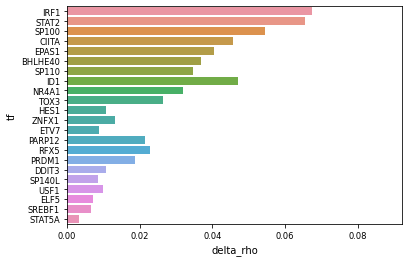

In [101]:
sns.barplot(y='tf', x='delta_rho', data=result_df.sort_values('delta_rho', ascending=False), errwidth=0)

Text(0.5, 0, '$\\Delta\\rho_{\\mathrm{ADJ}} - \\Delta\\rho$')

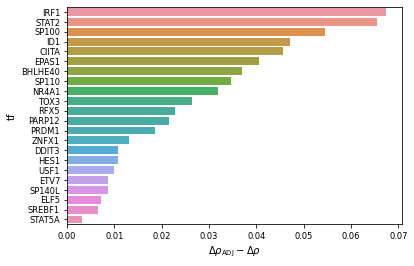

In [119]:
sns.barplot(y='tf', x='delta_rho', data=result_df.groupby('tf')['delta_rho'].mean().sort_values(ascending=False).reset_index(name='delta_rho'))
plt.xlabel(r'$\Delta\rho_{\mathrm{ADJ}} - \Delta\rho$')

In [120]:
pv = result_df.groupby('tf')['pv'].apply(lambda x: stats.combine_pvalues(x)[1]).sort_values()

In [123]:
fdr = memento.util._fdrcorrect(pv)

In [124]:
fdr

array([7.55244762e-05, 7.55244762e-05, 1.10957744e-03, 6.23741967e-03,
       6.23741967e-03, 1.32869976e-02, 2.27980676e-02, 4.69593632e-02,
       4.90070567e-02, 1.49024080e-01, 2.22171945e-01, 2.84743085e-01,
       3.56540155e-01, 5.81178396e-01, 5.81178396e-01, 5.81178396e-01,
       5.81178396e-01, 5.81178396e-01, 5.88793778e-01, 6.23966965e-01,
       6.29748894e-01, 6.87918333e-01])

In [63]:
delta, se = adjust('JUNB')
print(stats.norm.sf(delta, loc=0, scale=se))

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done   4 out of   7 | elapsed:    2.7s remaining:    2.0s
[Parallel(n_jobs=94)]: Done   7 out of   7 | elapsed:    3.8s finished
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done   4 out of   7 | elapsed:   10.0s remaining:    7.5s


[0.16144843 0.21353627 0.20754591 0.15573289 0.34621325 0.30872167
 0.52620379]


[Parallel(n_jobs=94)]: Done   7 out of   7 | elapsed:   14.5s finished


In [62]:
delta, se = adjust('CIITA')
print(stats.norm.sf(delta, loc=0, scale=se))

array([0.03102337, 0.07709145, 0.03047889, 0.1810527 , 0.11786292,
       0.10992212, 0.13843179])

### Run differential correlation between STAT1 and each stim's DEGs

In [22]:
ct = ['ciliated']
all_stims = ['gamma', 'lambda', 'alpha', 'beta']

In [91]:
for stim in all_stims:
    
    print('starting ', stim, '....')

    adata_stim = adata.copy()[
        adata.obs.cell_type.isin(ct) & \
        adata.obs.stim.isin(['control', stim])].copy()
    
    # time_converter={0:0, int('6'):1}
    adata_stim.obs['time_step'] = adata_stim.obs['time']#.astype(int).apply(lambda x: time_converter[x])
    adata_stim.obs['time'] = 'tp_' + adata_stim.obs['time'].astype(str)

    memento.create_groups(adata_stim, label_columns=['time', 'donor'])
    memento.compute_1d_moments(adata_stim, min_perc_group=.3)
    moment_1d_df = memento.get_1d_moments(adata_stim, groupby='time')

#     available_tfs = list(set(tf_list) & set(moment_1d_df[0].gene))
    available_targets = list(set(de_genes[stim if stim not in ['alpha', 'beta'] else 'alpha/beta']) & set(moment_1d_df[0].gene))

    memento.compute_2d_moments(adata_stim, list(itertools.product(['STAT1'], available_targets)))

#     moment_df = memento.get_2d_moments(adata_stim, groupby='time') 

#     moment_df['max_corr'] = moment_df.iloc[:, 2:].max(axis=1).values

#     candidates = moment_df.query('max_corr > 0.3 & gene_1 != gene_2')

# #     top_tfs = candidates.groupby('gene_1').size().sort_values(ascending=False)
# #     top_tfs = top_tfs[top_tfs > 15].index.tolist()

# #     candidates = candidates.query('gene_1 in @top_tfs')

#     candidates = list(zip(candidates['gene_1'], candidates['gene_2']))

#     memento.compute_2d_moments(adata_stim, candidates)

    memento.ht_2d_moments( 
        adata_stim, 
        formula_like='1 + time + donor',
        treatment_col='time', 
        num_boot=10000, 
        verbose=1,
        num_cpus=94,
        resampling='permutation',
        approx=False)
    
    adata_stim.write(data_path + 'stat1_coex_test/{}.h5ad'.format(stim))


starting  gamma ....


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/estimator.py:105: RuntimeWarning: invalid value encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:523: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:550: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:562: RuntimeWarning: invalid value encountered in true_divide
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 t

starting  lambda ....


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/estimator.py:105: RuntimeWarning: invalid value encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:523: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:550: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:562: RuntimeWarning: invalid value encountered in true_divide
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done 198 o

starting  alpha ....


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/estimator.py:105: RuntimeWarning: invalid value encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:523: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:550: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:562: RuntimeWarning: invalid value encountered in true_divide
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 t

starting  beta ....


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/estimator.py:105: RuntimeWarning: invalid value encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:523: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:550: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:562: RuntimeWarning: invalid value encountered in true_divide
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 t

In [ ]:
for stim in all_stims:
        
    print('starting ', stim, '....')

    adata_stim = adata.copy()[
        adata.obs.cell_type.isin(ct) & \
        adata.obs.stim.isin(['control', stim])].copy()
    
    time_converter={'0':0, '3':1, '6':2, '9':3, '24':4, '48':5}
    adata_stim.obs['time_step'] = adata_stim.obs['time']#.astype(int).apply(lambda x: time_converter[x])
    adata_stim.obs['time'] = 'tp_' + adata_stim.obs['time'].astype(str)#.apply(lambda x: time_converter[x])
    adata_stim.obs['is_stim'] = (adata_stim.obs.stim==stim).astype(int)

    memento.create_groups(adata_stim, label_columns=['is_stim','time', 'donor'])
    memento.compute_1d_moments(adata_stim, min_perc_group=.3)
    moment_1d_df = memento.get_1d_moments(adata_stim, groupby='time')

    available_targets = list(set(de_genes[stim]) & set(moment_1d_df[0].gene))

    memento.compute_2d_moments(adata_stim, list(itertools.product(['STAT1'], available_targets)))

    moment_df = memento.get_2d_moments(adata_stim, groupby='time') 

#     moment_df['max_corr'] = moment_df.iloc[:, 2:].max(axis=1).values

#     candidates = moment_df.query('max_corr > 0.3 & gene_1 != gene_2')

#     candidates = list(zip(candidates['gene_1'], candidates['gene_2']))

#     memento.compute_2d_moments(adata_stim, candidates)
    
    memento.ht_2d_moments( 
        adata_stim, 
        formula_like='1 + is_stim + donor',
        treatment_col='is_stim', 
        num_boot=10000, 
        verbose=1,
        num_cpus=94,
        resampling='permutation',
        approx=False)
    
    adata_stim.write(data_path + 'stat1_coex_test/{}_linear.h5ad'.format(stim))


starting  gamma ....


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/estimator.py:105: RuntimeWarning: invalid value encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:523: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:550: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:562: RuntimeWarning: invalid value encountered in true_divide
[Parallel(n_jobs=94)]: Using backend LokyBackend with 94 concurrent workers.
[Parallel(n_jobs=94)]: Done  12 t

starting  lambda ....


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/estimator.py:105: RuntimeWarning: invalid value encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:523: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:550: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:562: RuntimeWarning: invalid value encountered in true_divide
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/main.py:614: RuntimeWarn

### Read DC results

In [80]:
def classify(x):
    
    if x in shared_de_genes:
        return 'shared'
    elif x in shared_de_genes_lenient:
        return 'partially_shared'
    for stim in stims:
        if x in uniq_de_genes[stim]:
            return 'uniq_' + stim
    return 'none-DE'

In [145]:
deg_dc_results = {}
deg_2d_moments = {}
deg_m_moments = {}
deg_v_moments = {}
combined_results = {}

for stim in all_stims:
    
    adata_stim = sc.read(data_path + 'stat1_coex_test/{}_linear.h5ad'.format(stim))
    deg_dc_results[stim] = memento.get_2d_ht_result(adata_stim)
    deg_2d_moments[stim] = memento.get_2d_moments(adata_stim, groupby='time')[['gene_1','gene_2'] + ['time_'+str(i) for i in [0, 1, 2, 3, 4, 5]]]
#     deg_m_moments[stim],deg_v_moments[stim] = memento.get_1d_moments(adata_stim, groupby='time')
#     deg_m_moments[stim] = deg_m_moments[stim][['gene'] + ['time_'+str(i) for i in [0, 3, 6, 9, 24, 48]]]
#     deg_v_moments[stim] = deg_v_moments[stim][['gene'] + ['time_'+str(i) for i in [0, 3, 6, 9, 24, 48]]]
    deg_dc_results[stim]['corr_fdr'] = memento.util._fdrcorrect(deg_dc_results[stim]['corr_pval'])
    
    combined_results[stim] = deg_2d_moments[stim].merge(deg_dc_results[stim], on=['gene_1', 'gene_2'])
    combined_results[stim]['deg_type'] = combined_results[stim]['gene_2'].apply(classify)
    combined_results[stim]['sig'] =  (combined_results[stim]['corr_fdr'] < 0.05) & (combined_results[stim]['corr_coef'] > 0.0)
    
   

### Differential correlation and sharedness

In [146]:
a = deg_dc_results['lambda']

In [147]:
a['is_uniq'] = a['gene_2'].isin(uniq_de_genes['lambda'])

In [150]:
combined_results['lambda'].sort_values('corr_coef', ascending=False)

gene_1      gene_2    time_0    time_1    time_2    time_3    time_4  \
152  STAT1       GSTA4 -0.114069  0.216478  0.216478  0.217556  0.221651   
9    STAT1         ZYX -0.072388  0.078469  0.078469  0.073202  0.045811   
52   STAT1      CTDSP1 -0.265068  0.128000  0.128000  0.152787  0.106809   
189  STAT1       CHPT1 -0.139704  0.128094  0.128094  0.139944  0.177663   
153  STAT1         MYC -0.130424  0.099678  0.099678  0.089579  0.108588   
94   STAT1          F3 -0.074340  0.115347  0.115347  0.154803  0.093805   
76   STAT1    ATP6V1C2 -0.080710  0.131857  0.131857  0.132558  0.147808   
74   STAT1     SLC16A9 -0.022098  0.178907  0.178907  0.235420  0.124071   
55   STAT1       TOR1B  0.111860  0.352982  0.352982  0.381142  0.370164   
7    STAT1       VEGFA -0.018837  0.129133  0.129133  0.143994  0.109418   
98   STAT1      STEAP1  0.048260  0.172614  0.172614  0.180782  0.164188   
37   STAT1  SCAMP1-AS1  0.047819  0.280795  0.280795  0.306880  0.354042   
160  STAT1        WNK2  0.041992  0.135136  0.135136  0.121067  0.116247   
170  STAT1       FGFR3  0.036051  0.124595  0.124595  0.104229  0.153650   
21   STAT1       FAM3D -0.044193  0.090305  0.090305  0.101774  0.080245   
100  STAT1       NDRG1 -0.113567  0.071095  0.071095  0.080610  0.064662   
59   STAT1     SELENOP  0.055722  0.252042  0.252042  0.282401  0.231172   
62   STAT1    SERPINB3 -0.023008  0.134457  0.134457  0.154543  0.121850   
45   STAT1       UPK1B -0.051409  0.088815  0.088815  0.113882  0.038579   
105  STAT1       SOX21 -0.253096  0.108849  0.108849  0.113222  0.176204   
180  STAT1        AQP5 -0.014239  0.091718  0.091718  0.095540  0.100567   
128  STAT1      PARP12  0.542487  0.548401  0.548401  0.601882  0.470719   
174  STAT1       ADH1C -0.021387  0.126703  0.126703  0.131008  0.144304   
141  STAT1       NR4A1 -0.024365  0.076676  0.076676  0.063658  0.104263   
148  STAT1        KRT4 -0.089979  0.067129  0.067129  0.082770  0.073555   
104  STAT1       ADIRF -0.013170  0.119454  0.119454  0.129363  0.095782   
5    STAT1        VWA1 -0.057951  0.176219  0.176219  0.212373  0.154627   
194  STAT1      CYP2F1  0.000714  0.117311  0.117311  0.140094  0.089227   
47   STAT1       EPAS1  0.124265  0.175369  0.175369  0.194689  0.158329   
51   STAT1        GJB2 -0.138582  0.044267  0.044267  0.016152  0.092593   
172  STAT1      ADAM28  0.068312  0.180955  0.180955  0.200665  0.142749   
3    STAT1      NIBAN1  0.163089  0.195036  0.195036  0.223136  0.162597   
20   STAT1    LGALS3BP  0.430387  0.504815  0.504815  0.582499  0.384862   
190  STAT1      PRSS23  0.005957  0.147572  0.147572  0.151297  0.149191   
144  STAT1        TLE3  0.019787  0.176301  0.176301  0.207903  0.146736   
28   STAT1        LMO4  0.096260  0.263948  0.263948  0.314180  0.233149   
71   STAT1        EDN2 -0.088022  0.079324  0.079324  0.076015  0.111674   
193  STAT1       TCEA3  0.073869  0.116450  0.116450  0.126086  0.078985   
72   STAT1     ZFP36L1  0.067245  0.251065  0.251065  0.264123  0.204903   
198  STAT1       IFIH1  0.591019  0.625576  0.625576  0.724752  0.527733   
197  STAT1    CDC42EP5 -0.016927  0.095755  0.095755  0.124270  0.049499   
95   STAT1       DUSP5 -0.018986  0.074759  0.074759  0.077460  0.077929   
82   STAT1       KLK11  0.044554  0.092658  0.092658  0.114770  0.068172   
169  STAT1       SNHG5 -0.189709  0.112735  0.112735  0.075299  0.193043   
84   STAT1      CDKN1C -0.083720  0.040126  0.040126  0.023938  0.039276   
136  STAT1     TNFSF10  0.372153  0.425077  0.425077  0.473987  0.370600   
177  STAT1       HCAR2 -0.089639  0.168731  0.168731  0.221504  0.138665   
103  STAT1       PTHLH -0.147056  0.044652  0.044652  0.026509  0.072741   
132  STAT1      GPRC5A  0.131936  0.128788  0.128788  0.151891  0.117460   
11   STAT1      TRIM14  0.236069  0.421705  0.421705  0.407149  0.450174   
79   STAT1      RNASE1 -0.086667  0.048683  0.048683  0.061561  0.038049   
182  STAT1       CMYA5  0.103425  0.239263  0.239263

In [138]:
deg_dc_results['lambda']#.query('deg_type=="shared"')

gene_1      gene_2  corr_coef   corr_se  corr_pval  corr_fdr  \
0    STAT1        FUT2   0.027354  0.026838   0.301670  0.455959   
1    STAT1       SP100  -0.025332  0.019409   0.191181  0.337980   
2    STAT1    U62317.4  -0.023812  0.019326   0.216178  0.365840   
3    STAT1      NIBAN1   0.055524  0.019968   0.005799  0.022966   
4    STAT1      PARP14   0.037395  0.012909   0.003700  0.015924   
5    STAT1        VWA1   0.059357  0.033733   0.077392  0.178182   
6    STAT1       DDIT4   0.022083  0.012699   0.082092  0.186830   
7    STAT1       VEGFA   0.080101  0.018003   0.000309  0.011313   
8    STAT1        PIM3   0.041044  0.018885   0.028397  0.081488   
9    STAT1         ZYX   0.100967  0.032542   0.003100  0.013949   
10   STAT1        IQCN   0.044072  0.033838   0.188881  0.336923   
11   STAT1      TRIM14   0.048338  0.029859   0.105589  0.222412   
12   STAT1      PARP10   0.025714  0.027619   0.348665  0.496802   
13   STAT1       CXCL8   0.039882  0.012822   0.002400  0.011879   
14   STAT1        IDO1  -0.037621  0.020755   0.072493  0.170876   
15   STAT1      CAPN15  -0.053005  0.038249   0.160884  0.303381   
16   STAT1     DPY19L2   0.006509  0.032521   0.837416  0.901133   
17   STAT1       IFI44   0.016663  0.015606   0.288271  0.445919   
18   STAT1       ZFP36   0.038009  0.016812   0.023998  0.070918   
19   STAT1       IFIT2   0.024140  0.015965   0.130687  0.261334   
20   STAT1    LGALS3BP   0.054305  0.018176   0.002500  0.012072   
21   STAT1       FAM3D   0.068227  0.013300   0.000796  0.011313   
22   STAT1        OAS3   0.015088  0.019278   0.431457  0.569523   
23   STAT1     EIF2AK2   0.031477  0.016000   0.050095  0.128816   
24   STAT1        ABAT   0.025719  0.031347   0.405859  0.542974   
25   STAT1        HES1   0.021995  0.013918   0.113889  0.237368   
26   STAT1       KRT6A   0.009664  0.018405   0.583642  0.704641   
27   STAT1       PTGFR   0.045197  0.021153   0.033897  0.091939   
28   STAT1        LMO4   0.053459  0.016815   0.003200  0.014081   
29   STAT1        ETV7   0.037565  0.029947   0.211379  0.360802   
30   STAT1        MSLN   0.014636  0.014465   0.313969  0.470953   
31   STAT1       SP110   0.001366  0.018484   0.941906  0.970718   
32   STAT1  AC104695.4   0.011528  0.022532   0.609139  0.722039   
33   STAT1         MNT   0.023914  0.030166   0.422158  0.560988   
34   STAT1        FOSB   0.042756  0.016318   0.010199  0.036061   
35   STAT1       STAT1        NaN       NaN        NaN  1.000000   
36   STAT1        BTG2   0.004039  0.013199   0.765223  0.856013   
37   STAT1  SCAMP1-AS1   0.076771  0.035568   0.032097  0.088266   
38   STAT1     SCGB1A1   0.034984  0.010718   0.002207  0.011436   
39   STAT1  SLC9A3-AS1   0.027948  0.025319   0.264774  0.417330   
40   STAT1     TNFAIP3   0.015365  0.018365   0.399260  0.537779   
41   STAT1        TCN1   0.043416  0.013958   0.001900  0.011436   
42   STAT1     KLHDC7B   0.025107  0.022308   0.260274  0.415599   
43   STAT1        IFI6  -0.068502  0.011577   0.000659  0.011313   
44   STAT1       KRT17   0.005422  0.013610   0.691731  0.800951   
45   STAT1       UPK1B   0.065694  0.014619   0.001300  0.011313   
46   STAT1      SPTSSB   0.016798  0.024700   0.493251  0.632770   
47   STAT1       EPAS1   0.057029  0.014428   0.001291  0.011313   
48   STAT1       HERC5   0.032631  0.016577   0.047095  0.122696   
49   STAT1      TRANK1   0.006224  0.038161   0.869713  0.920873   
50   STAT1      ZNF117  -0.099566  0.038392   0.011099  0.037889   
51   STAT1        GJB2   0.056541  0.021718   0.011299  0.037918   
52   STAT1      CTDSP1   0.091377  0.037092   0.013799  0.044789   
53   STAT1       SAMD9   0.001975  0.013890   0.886011  0.933140   
54   STAT1      SREBF1   0.029063  0.023702   0.218378  0.366431   
55   STAT1       TOR1B   0.082824  0.034430   0.015898  0.050772   
56   STAT1      IFITM1  -0.007856  0.013523   0.557344  0.677019   
57   STAT1        ELF5   0.040288  0.033260   0.220878  0.36

In [120]:
for stim in all_stims:
    
    contingency = pd.crosstab(
        deg_dc_results[stim]['deg_type']=='shared', 
        deg_dc_results[stim]['sig'])
    print(stim)
    print(contingency)
    print(stim, stats.fisher_exact(contingency))

gamma
sig       False  True 
deg_type              
False        80    128
True         54     58
gamma (0.6712962962962963, 0.09758328740019982)
lambda
sig       False  True 
deg_type              
False        53     34
True         75     37
lambda (0.7690196078431373, 0.4559317190052937)
alpha
sig       False  True 
deg_type              
False       223    220
True         34     67
alpha (1.9974598930481284, 0.002785560119163853)
beta
sig       False  True 
deg_type              
False       247    281
True         23     89
beta (3.40136159678168, 1.7453076407822353e-07)


In [82]:
ht_2d_df = memento.get_2d_ht_result(adata_stim)
ht_2d_df['corr_fdr'] = memento.util._fdrcorrect(ht_2d_df['corr_pval'])
sig_df = ht_2d_df.query('corr_fdr < 0.1')

In [83]:
tp_order = ['time_tp_' + str(i) for i in [0, 3, 6, 9, 24, 48]]

In [90]:
moment_1d_df[0].query('gene == "CIITA"')[tp_order]

time_tp_0  time_tp_3  time_tp_6  time_tp_9  time_tp_24  time_tp_48
8497  -2.216917  -0.133482  -0.250962  -0.205729   -0.256063   -0.471048

In [85]:
dra=moment_df.merge(sig_df[['gene_1', 'gene_2']], on=['gene_1', 'gene_2'], how='inner')\
    .query('gene_2.str.startswith("HLA-DRA")', engine='python')[['gene_1', 'gene_2'] + tp_order]

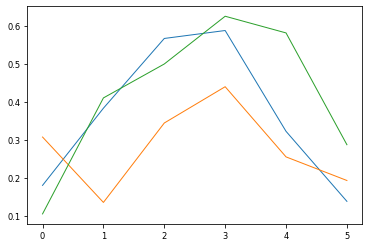

In [86]:
plt.plot(dra[tp_order].values.T, lw=1);